In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

import xgboost

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Purpose of this notebook

Also try to use the coordinates as presented from the group 'Greyjoy'. 
But also add more information: The distance to the epicenter of the earthquake. 

In [2]:
train_data = pd.read_csv("../../data/raw/train_values.csv", index_col="building_id")
y_train = pd.read_csv("../../data/raw/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

In [3]:
encoder = LabelEncoder()
train_labels = encoder.fit_transform(y_train["damage_grade"].to_numpy())

In [4]:
geocoded_districts = pd.read_csv("../../data/processed/geocoded_districts_relative_number.csv")

In [5]:
geocoded_districts.head()

,dcode,district,loc,latitude,longitude,cases_absolute,cases_total,cases_relative
0,7,Dhankuta,POINT (830923.6221963036 2990403.9441179214),2.990404e+06,830923.622196,4491,996588,0.450638
1,9,Sankhuwasabha,POINT (823967.8875543519 3055813.003124751),3.055813e+06,823967.887554,4966,996588,0.498300
2,10,Bhojpur,POINT (804271.7821892153 3010893.8427118193),3.010894e+06,804271.782189,9242,996588,0.927364
3,11,Solukhumbhu,POINT (768535.2635735668 3068706.4528159057),3.068706e+06,768535.263574,17000,996588,1.705820
4,12,Okhaldhunga,POINT (739586.4122948735 3025872.434064191),3.025872e+06,739586.412295,36480,996588,3.660490


In [6]:
geocoded_districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dcode           31 non-null     int64  
 1   district        31 non-null     object 
 2   loc             31 non-null     object 
 3   latitude        31 non-null     float64
 4   longitude       31 non-null     float64
 5   cases_absolute  31 non-null     int64  
 6   cases_total     31 non-null     int64  
 7   cases_relative  31 non-null     float64
dtypes: float64(3), int64(3), object(2)
memory usage: 2.1+ KB


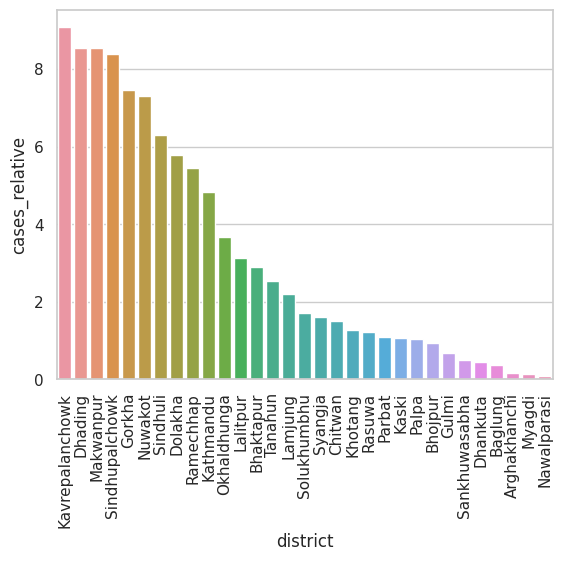

In [7]:
#plt.figure(figsize=(15,5))
g = sns.barplot(geocoded_districts.sort_values("cases_absolute", ascending=False),  
                x="district", 
                y="cases_relative",)

for item in g.get_xticklabels():
    item.set_rotation(90)
#g.set_xticklabels(rotation=90)

In [8]:
# Get distribution of our data set
result = pd.DataFrame(columns=["geo_level_1_id", "total"])

data = {
    "geo_level_1_id": train_data.reset_index()["geo_level_1_id"], 
    "total"         : [1] * train_data.shape[0]
}
result = pd.DataFrame(data=data)
result = result.groupby("geo_level_1_id").count()
result["ratio"] = 100 * result["total"] / train_data.shape[0]
result = result.reset_index().sort_values("total", ascending=False)

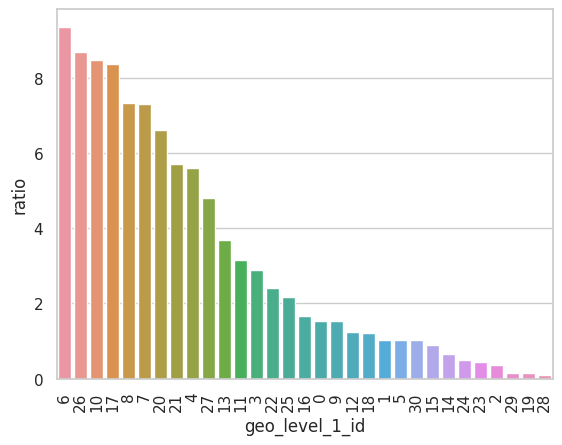

In [9]:
# Plot results
g = sns.barplot(result,  
                x="geo_level_1_id", 
                y="ratio",
                order=result.sort_values('ratio', ascending=False).geo_level_1_id)

for item in g.get_xticklabels():
    item.set_rotation(90)

The plots look pretty similar, also the values are similar.
(Also matches the information given in the presentation of the other group).

$\Rightarrow$ create a mapping between the geo_level_1_ids and the names and positions of the districts. 

In [10]:
sorted_geo_level_1_ids = list(result.sort_values('ratio', ascending=False).geo_level_1_id)

district_mapping = geocoded_districts.sort_values("cases_absolute", ascending=False)
district_mapping["geo_level_1_id"] = sorted_geo_level_1_ids
district_mapping.head()

,dcode,district,loc,latitude,longitude,cases_absolute,cases_total,cases_relative,geo_level_1_id
10,24,Kavrepalanchowk,POINT (660172.7511581221 3047402.9516771147),3.047403e+06,660172.751158,90497,996588,9.080683,6
16,30,Dhading,POINT (594662.4464236646 3093171.805756474),3.093172e+06,594662.446424,85255,996588,8.554689,26
17,31,Makwanpur,POINT (606893.011749543 3039579.495623507),3.039579e+06,606893.011750,85188,996588,8.547966,10
9,23,Sindhupalchowk,POINT (671458.8329532298 3089631.706769355),3.089632e+06,671458.832953,83589,996588,8.387518,17
19,36,Gorkha,POINT (577663.7704127206 3133385.98766555),3.133386e+06,577663.770413,74389,996588,7.464368,8


## Distance to epicenter

We can download the shapefile of Nepal along with its districts here: https://codefornepal.carto.com/tables/shape_files_of_districts_in_nepal/public

The information where the epicenter of the earthquake was can be found here: https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake

Epicenter: 28.230°N 84.731°E

In [11]:
import geopandas as gpd

In [12]:
shapes = gpd.read_file("../../data/raw/shape_files_of_districts_in_nepal/shape_files_of_districts_in_nepal.shp")

In [13]:
shapes.head()

,descriptio,name,objectid,dist_code,dist_name,shape_area,shape_len,cartodb_id,created_at,updated_at,geometry
0,NaN,NaN,1,56,Humla,0.563069,4.716705,1,2015-02-21,2015-02-21,"POLYGON ((81.39931 30.35919, 81.39867 30.36063..."
1,NaN,NaN,2,72,Darchula,0.218681,2.558935,2,2015-02-21,2015-02-21,"POLYGON ((81.09047 30.05482, 81.08816 30.05540..."
2,NaN,NaN,3,69,Bajhang,0.324637,2.885682,3,2015-02-21,2015-02-21,"POLYGON ((81.09047 30.05482, 81.09086 30.05368..."
3,NaN,NaN,4,53,Mugu,0.300001,3.600518,4,2015-02-21,2015-02-21,"POLYGON ((82.49875 29.95081, 82.50055 29.94802..."
4,NaN,NaN,5,67,Bajura,0.212234,2.661084,5,2015-02-21,2015-02-21,"POLYGON ((81.50617 29.89601, 81.50912 29.89775..."


<Axes: >

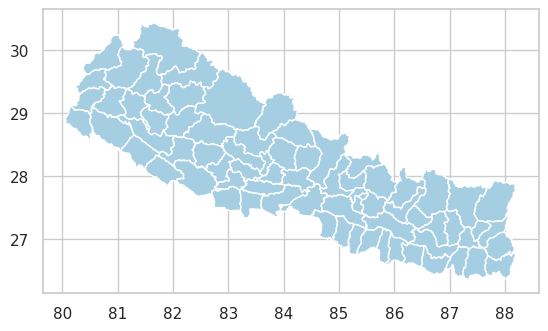

In [14]:
%matplotlib inline
shapes.plot()

<Axes: >

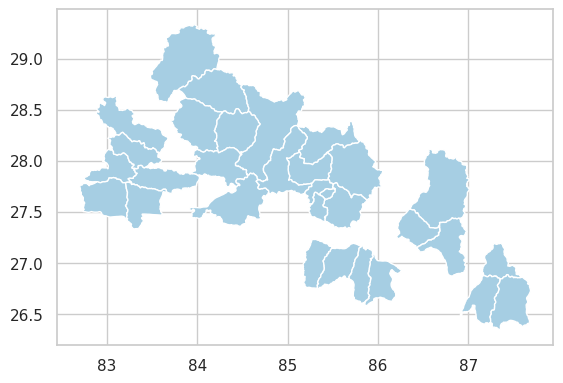

In [15]:
shapes[shapes["dist_code"].isin(list(district_mapping["dcode"]))].plot()

<Axes: >

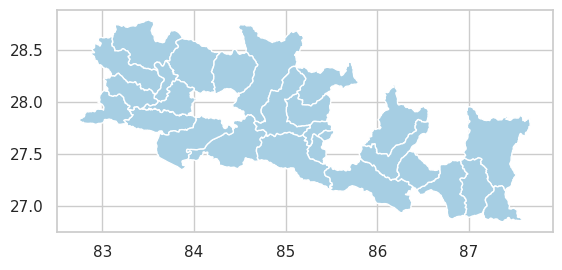

In [16]:
# Since the dist codes do not match, try the district names
shapes[shapes["dist_name"].isin(list(district_mapping["district"]))].plot()

In [17]:
print(district_mapping["district"])

10    Kavrepalanchowk
16            Dhading
17          Makwanpur
9      Sindhupalchowk
19             Gorkha
14            Nuwakot
6            Sindhuli
8             Dolakha
7           Ramechhap
13          Kathmandu
4         Okhaldhunga
11           Lalitpur
12          Bhaktapur
21            Tanahun
20            Lamjung
3         Solukhumbhu
22            Syangja
18            Chitwan
5             Khotang
15             Rasuwa
25             Parbat
23              Kaski
28              Palpa
2             Bhojpur
27              Gulmi
1       Sankhuwasabha
0            Dhankuta
26            Baglung
30       Arghakhanchi
24             Myagdi
29        Nawalparasi
Name: district, dtype: object


In [18]:
for dname in district_mapping["district"]:
    if dname not in list(shapes["dist_name"]):
        print(dname)

Kavrepalanchowk
Sindhupalchowk
Tanahun
Solukhumbhu


In [19]:
set(shapes["dist_name"]) - set(district_mapping["district"])

{'Achham',
 'Baitadi',
 'Bajhang',
 'Bajura',
 'Banke',
 'Bara',
 'Bardiya',
 'Dadeldhura',
 'Dailekh',
 'Dang',
 'Darchula',
 'Dhanusa',
 'Dolpa',
 'Doti',
 'Humla',
 'Ilam',
 'Jajarkot',
 'Jhapa',
 'Jumla',
 'Kailali',
 'Kalikot',
 'Kanchanpur',
 'Kapilbastu',
 'Kavrepalanchok',
 'Mahottari',
 'Manang',
 'Morang',
 'Mugu',
 'Mustang',
 'Panchthar',
 'Parsa',
 'Pyuthan',
 'Rautahat',
 'Rolpa',
 'Rukum',
 'Rupandehi',
 'Salyan',
 'Saptari',
 'Sarlahi',
 'Sindhupalchok',
 'Siraha',
 'Solukhumbu',
 'Sunsari',
 'Surkhet',
 'Tanahu',
 'Taplejung',
 'Tehrathum',
 'Udayapur'}

I guess it is because of the translation from their mother language. 
But the mapping I perform will be as following: 

- The 27 districts which names match, will be matched
- Kavrepalanchowk $\rightarrow$ Kavrepalanchok
- Sindhupalchowk $\rightarrow$ Sindhupalchok
- Tanahun $\rightarrow$ Tanahu
- Solukhumbhu $\rightarrow$ Solukhumbu

In [20]:
replacements = {
    "Kavrepalanchowk": "Kavrepalanchok", 
    "Sindhupalchowk" : "Sindhupalchok",
    "Tanahun"        : "Tanahu",
    "Solukhumbhu"    : "Solukhumbu"
}

district_mapping = district_mapping.replace(replacements)

<Axes: >

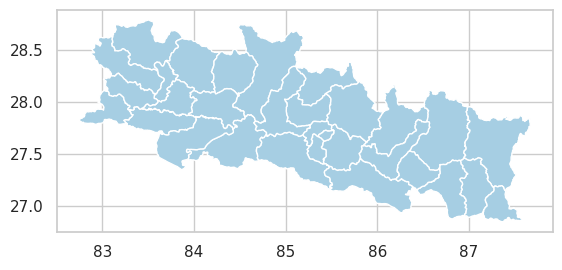

In [21]:
shapes[shapes["dist_name"].isin(list(district_mapping["district"]))].plot()

This looks like the map of the affected districts from https://www.sciencedirect.com/topics/earth-and-planetary-sciences/gorkha-earthquake-2015. 
So I keep this mapping and now calculate the min and max distance from each district to the epicenter.

The CRS depends on the location. 
Nepal (and also the observed region) lies in UTM zone 44 and 45. 
Since the larger part lies in '45 I will use this CRS for calculating the distance. 

For reference see https://epsg.io/32644 and https://epsg.io/32645
The unit in this zone are meters

<Axes: >

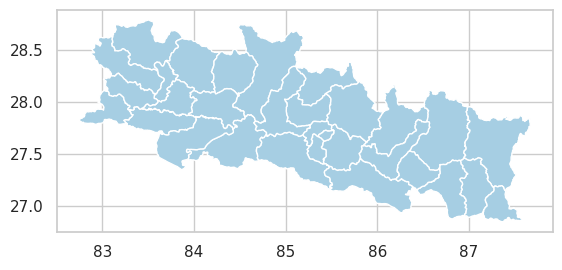

In [22]:
from shapely.geometry import Point
#from geoindex import GeoPoint

epicenter = Point(84.731, 28.230)
shapes[shapes["dist_name"].isin(list(district_mapping["district"]))].plot()

<Axes: >

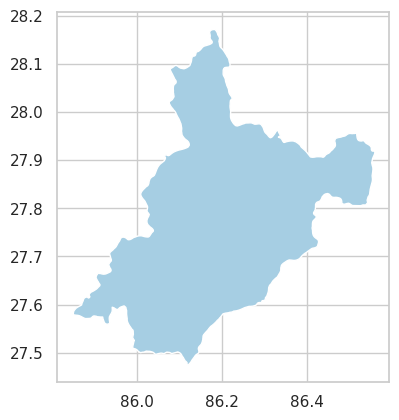

In [23]:
shapes[shapes["dist_name"].isin(list(district_mapping["district"]))][:1].plot()

In [24]:
test_district = shapes[shapes["dist_name"].isin(list(district_mapping["district"]))][:1]

In [25]:
test_district.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
# Min distance to district
from shapely.geometry import Point

series = gpd.GeoSeries(test_district.geometry)
series.crs = 4326
series = series.to_crs("EPSG:32645")

epicenter = gpd.GeoSeries([Point(84.731, 28.230)])
epicenter.crs = 4326
epicenter = epicenter.to_crs("EPSG:32645")

dist = series.distance(epicenter, align=False)
print(round(dist, 4))

17    131265.4389
dtype: float64


In [27]:
dist.iloc[0]

131265.4388652015

In [28]:
# Max distance to district
epicenter = gpd.GeoSeries([Point(84.731, 28.230)])
epicenter.crs = 4326
epicenter = epicenter.to_crs("EPSG:32645")
print(epicenter)

max_dist = 0
min_dist = 500000
all_coords = []
# Do this for every district:
for b in series.boundary: 
    coords = np.dstack(b.coords.xy).tolist()
    if len(coords) != 1:
        print("\nCheck manually\n")
    coords = coords[0]
        
    # Traverse all points in this district
    for p in coords:
        t = gpd.GeoSeries([Point(p[0], p[1])])
        t.crs = 32645

        temp_dist = t.distance(epicenter, align=False)
        temp_dist = temp_dist.iloc[0]

        if temp_dist < min_dist:
            min_dist = temp_dist
        if temp_dist > max_dist:
            max_dist = temp_dist
    

# min_dist should be >= distance in cell above
# max_dist should be >> distance in cell above
print(min_dist)
print(max_dist)

0    POINT (277349.290 3124767.126)
dtype: geometry
131265.4388652015
183968.30888022276


## Calculate min and max distance to the epicenter for all districts

In [29]:
def min_dist(row):
    series = gpd.GeoSeries(row.geometry)
    series.crs = 4326
    series = series.to_crs("EPSG:32645")

    epicenter = gpd.GeoSeries([Point(84.731, 28.230)])
    epicenter.crs = 4326
    epicenter = epicenter.to_crs("EPSG:32645")

    dist = series.distance(epicenter, align=False)
    
    return round(dist.iloc[0], 0) / 1000

In [30]:
def max_dist(row):
    epicenter = gpd.GeoSeries([Point(84.731, 28.230)])
    epicenter.crs = 4326
    epicenter = epicenter.to_crs("EPSG:32645")
    
    s = gpd.GeoSeries(row.geometry)
    s.crs = 4326
    s = s.to_crs("EPSG:32645")
    
    #print(f"district: {row.district}")
    #print(f"geometry: {s}\n")
    
    max_dist = 0
    # Traverse all points in the current districts shape file
    for b in s.boundary: 
        coords = np.dstack(b.coords.xy).tolist()
        if len(coords) != 1:
            print(f"\nCheck manually on {row.district}\n")
        coords = coords[0]

        # Traverse all points in this district
        for p in coords:
            t = gpd.GeoSeries([Point(p[0], p[1])])
            t.crs = 32645

            temp_dist = t.distance(epicenter, align=False)
            temp_dist = temp_dist.iloc[0]

            if temp_dist > max_dist:
                max_dist = temp_dist
    
    return round(max_dist, 0) / 1000

In [31]:
# Use the district_mapping: it contains geo_level_1_id, and geometry
# Traverse every row in this data frame, 
# write its results to new lists, 
# add the lists as new columns and 
# export the needed information

# Get only the relevant information in one dataframe
all_districts = shapes[shapes["dist_name"].isin(list(district_mapping["district"]))].copy()
all_districts = all_districts[["dist_name", "geometry"]]
all_districts = all_districts.merge(district_mapping[["district", "geo_level_1_id"]], left_on="dist_name", right_on="district", how="inner")
all_districts = all_districts[["district", "geo_level_1_id", "geometry"]]

all_districts.head()

,district,geo_level_1_id,geometry
0,Dolakha,21,"POLYGON ((86.51530 27.95726, 86.51585 27.95514..."
1,Myagdi,19,"POLYGON ((83.48736 28.79002, 83.49387 28.79057..."
2,Gorkha,8,"POLYGON ((84.49077 28.73709, 84.50418 28.74624..."
3,Baglung,2,"POLYGON ((82.88142 28.47601, 82.88218 28.47734..."
4,Kaski,5,"POLYGON ((84.27761 28.47124, 84.27466 28.46636..."


In [32]:
all_districts["min_distance_to_epicenter"] = all_districts.apply(min_dist, axis=1)

In [33]:
%%time 
all_districts["max_distance_to_epicenter"] = all_districts.apply(max_dist, axis=1)

CPU times: user 56.3 s, sys: 1.46 s, total: 57.8 s
Wall time: 59 s


In [34]:
all_districts

,district,geo_level_1_id,geometry,min_distance_to_epicenter,max_distance_to_epicenter
0,Dolakha,21,"POLYGON ((86.51530 27.95726, 86.51585 27.95514...",131.265,183.968
1,Myagdi,19,"POLYGON ((83.48736 28.79002, 83.49387 28.79057...",94.401,165.805
2,Gorkha,8,"POLYGON ((84.49077 28.73709, 84.50418 28.74624...",0.000,63.833
3,Baglung,2,"POLYGON ((82.88142 28.47601, 82.88218 28.47734...",103.755,184.598
4,Kaski,5,"POLYGON ((84.27761 28.47124, 84.27466 28.46636...",50.364,102.870
5,Lamjung,25,"POLYGON ((84.56623 28.48762, 84.57141 28.48128...",8.395,53.637
6,Parbat,1,"POLYGON ((83.60348 28.29854, 83.60414 28.30170...",89.091,116.640
7,Rasuwa,18,"POLYGON ((85.11954 28.33554, 85.12212 28.33612...",39.509,104.284
8,Tanahu,22,"POLYGON ((84.00257 28.11616, 84.00483 28.11272...",30.827,86.990
9,Solukhumbu,16,"POLYGON ((86.51530 27.95726, 86.51461 27.95900...",176.899,234.762


According to https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake the epicenter is in Gorkha, which can also seen from the calculated min distance. 

All the distances are now given in km

In [35]:
# Save results
all_districts = all_districts[["district", "geo_level_1_id", "min_distance_to_epicenter", "max_distance_to_epicenter"]]
all_districts.to_csv("../../data/processed/geo_level_1_id_mapping_and_distances_to_epicenter.csv")
